In [2]:
import json
import os
from datetime import datetime
import collections

import matplotlib.pyplot as plt
import pandas as pd
import numpy as np

plt.style.use('fivethirtyeight')

# eg: 2018-04-09T17:07:56Z
date_fmt = "%Y-%m-%dT%H:%M:%SZ"

def load_data(path):
    to_date = datetime.strptime
    with open(path) as fp:
        return pd.DataFrame({
                "created": to_date(article['webPublicationDate'], date_fmt),
                "title": article['webTitle'],
                "tags": read_tags(article['tags'])} 
            for article in json.load(fp))

def read_tags(raw_tags):
    return [k['webTitle'] 
            for k in raw_tags
            if k['type'] == 'keyword']

In [29]:
data = {}
for root, dirs, files in os.walk("../data/guardian/series/"):
    for f in files:
        title = f.split(".")[0].replace("_", " ")
        print(title, root + f)
        data[title] = load_data(root + f)

data protection ../data/guardian/series/data_protection.json
facebook ../data/guardian/series/facebook.json
Internet ../data/guardian/series/Internet.json
privacy ../data/guardian/series/privacy.json


we will just see how many unique tags their are before moving on.

In [3]:
def count_tags(terms, stopwords=set()):
    tc = collections.Counter()
    for t in terms:
        tc.update(t)
    print("total unique:", len(tc))
    return tc

def plot_counter(counter, n=20, title=None):
    labels, values = list(zip(*counter.most_common(n)[::-1]))
    fig, ax = plt.subplots()
    ind = np.arange(len(labels))
    width = 0.6
    a = ax.barh(ind, values, width)
    ax.set_yticks(ind)
    ax.set_yticklabels(labels)
    ax.legend(a, ("counts",))
    if title is not None:
        ax.set_title(title, y=1.05)
    plt.show()

In [4]:
# how far the data ranges
date_range = lambda a: (max(a['created']) - min(a['created'])).days / 365

for k, v in data.items():
    print(k, date_range(v))

data protection 8.35068493150685
Internet 8.347945205479451
privacy 8.347945205479451
facebook 8.347945205479451


total unique: 6972


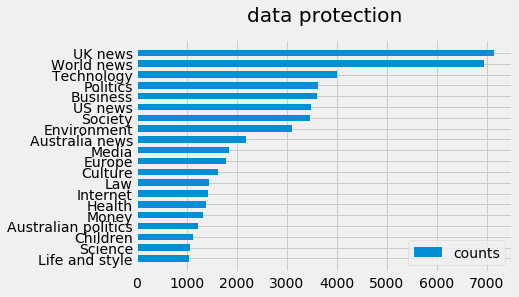

total unique: 8970


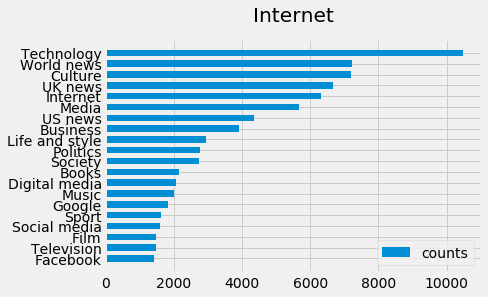

total unique: 5609


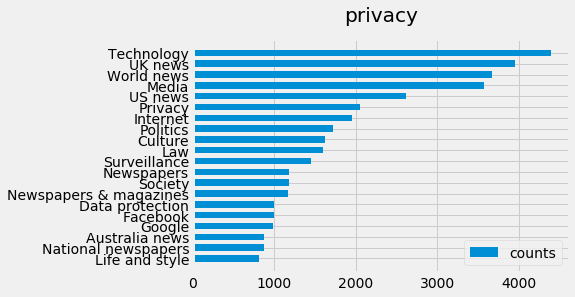

total unique: 8232


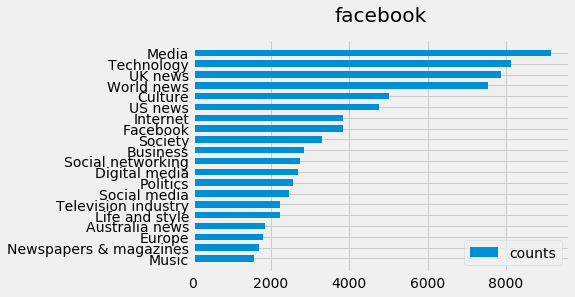

In [5]:
for k, v in data.items():
    plot_counter(count_tags(v['tags']), title=k)

In [6]:
def plot_term_series(data, *terms, **kwargs):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5)
    for k, df in data.items():
        df['freq'] = 1
        ts = df.set_index('created').resample('M').sum()
        ts.plot(ax=ax, y="freq", label=k, **kwargs)
    plt.show()

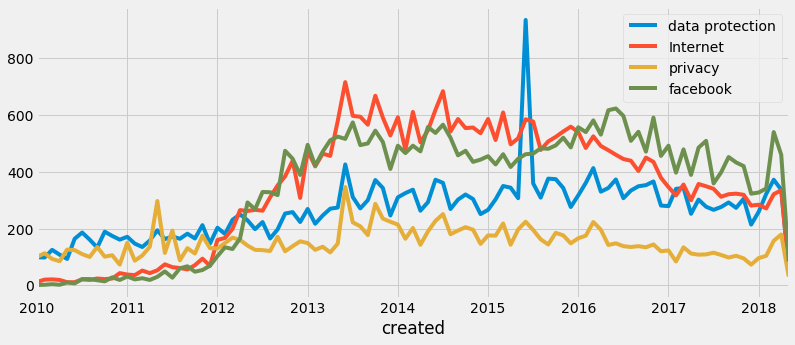

In [7]:
plot_term_series(data)

https://www.theguardian.com/world/interactive/2013/nov/01/snowden-nsa-files-surveillance-revelations-decoded#section/1

snowden 2013

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

stop_words = set(open("../resources/more_stopwords.txt").read().split())
stop_words |= set('''
stories story asked chat paper papers live qs daily society today
weekly video podcast guardian blog world change shows view views
rankings mail morning dies university 2018
'''.split())

def plot_ngrams(text, n0, n1, n_features=10000, **kwargs):
    fig, ax = plt.subplots()
    i = 0
    tfidf_vect = TfidfVectorizer(max_df=0.5, min_df=2, 
                                 max_features=n_features,
                                 ngram_range=(2,2),
                                 stop_words=stop_words)
    tfidf_features = tfidf_vect.fit_transform(text)
    vocab = tfidf_vect.get_feature_names()
    values = tfidf_features.toarray().mean(axis=0)
    sample = [(values[i], k) for i, k in enumerate(vocab)]
    v, k = zip(*sorted(sample, reverse=True)[:10])
    dd = pd.DataFrame(index=k, data={"key": k, "tfidf": v})
    dd.plot(kind="barh", ax=ax, legend=False, **kwargs).invert_yaxis()
    plt.tight_layout()
    plt.show()

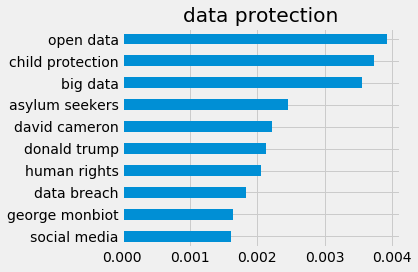

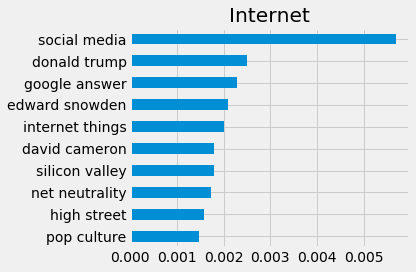

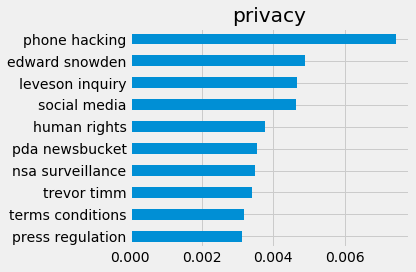

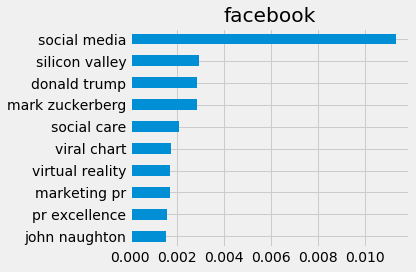

In [20]:
for k, v in data.items():
    plot_ngrams(v['title'], 2, 2, title=k)

# Sentiment



In [18]:
from textblob import TextBlob

In [36]:
def polarity(t):
    return TextBlob(t).sentiment[0]

def plot_sentiments(data, *args, **kwargs):
    fig, ax = plt.subplots()
    fig.set_size_inches(12, 5)
    for k, df in data.items():
        df["polarity"] = df['title'].apply(polarity)
        ts = df.set_index('created').resample('6M').mean()
        ts.plot(ax=ax, y="polarity", label=k, **kwargs)
    plt.show()

In [ ]:
plot_sentiments(data)